In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import editdistance

from riken.word2vec import classification_tools
from riken.protein_io import reader

In [2]:
max_len = 1000

VOCAB = list('MRLYGNQXWKDHSEPTFACZIV')

pfam_file = '/home/pierre/riken/data/pfam/Pfam-A.fasta'
clans_families_path = '/home/pierre/riken/data/pfam/Pfam-A.clans.tsv'
swiss_data = '/home/pierre/riken/data/swiss/swiss_with_clans.tsv'

allergens_path = '/home/pierre/riken/data/riken_data/complete_from_xlsx.tsv'
n_sample = 1000

model_path = '/home/pierre/riken/word2vec/prot_vec_model_10_epochs_l_4.model'

In [3]:
swiss_df = pd.read_csv(swiss_data, sep='\t').dropna().assign(sequences=lambda x: x.sequences_x,
                                                             seq_len=lambda x: x.sequences_x.apply(len))

In [ ]:
pfam_df = reader.read_fasta(pfam_file)
info = pfam_df.description.str.split(r'\s|;', expand=True) \
    .iloc[:, 0:4] \
    .rename(columns={0:'protein_loc', 1: 'protein_tag', 2: 'family', 3:'family_name'})
pfam_df = pfam_df.drop(columns=['description', 'id', 'name'])
pfam_df = pd.concat([pfam_df, info], axis=1, ignore_index=False)
pfam_df.loc[:, 'family'] = pfam_df.family.str.split('.', expand=True).iloc[:, 0]

family_clans = pd.read_csv(clans_families_path, sep='\t', 
                           names=['family', 'clan', 'clan_name', 'family_name', 'family_description'])

pfam_df = pd.merge(left=pfam_df, right=family_clans, on='family', how='left')

pfam_df.loc[:, 'seq_len'] = pfam_df.sequences.apply(len)

In [ ]:
allergens_df = pd.read_csv(allergens_path, sep='\t').assign(seq_len=lambda x: x.sequences.apply(len))
# allergens_df = allergens_df.loc[lambda x: x.is_allergenic]

In [ ]:
swiss_df = swiss_df[swiss_df.seq_len <= max_len]
allergens_df = allergens_df[allergens_df.seq_len <= max_len]
pfam_df = pfam_df[pfam_df.seq_len <= max_len]

In [ ]:
print(pfam_df.info())
pfam_df.groupby('clan').family.count()

# Sampling

In [12]:
# pfam_sample = pfam_df.sample(n_sample)
swiss_sample = swiss_df.sample(n_sample)
allergens_sample = allergens_df.sample(n_sample)

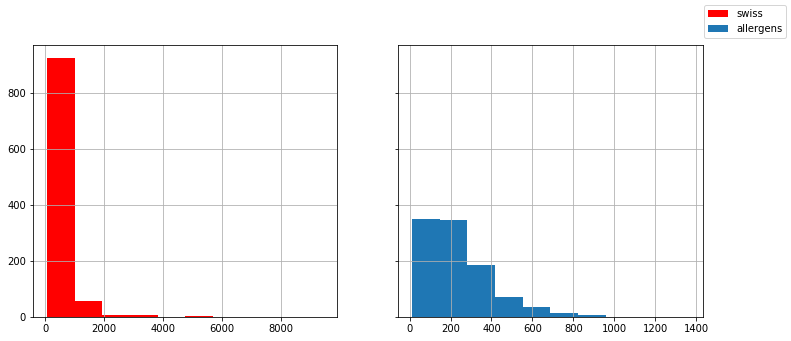

In [13]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 5))
# pfam_sample.sequences.apply(len).hist(ax=axes[0], color='red', label='pfam')
swiss_sample.sequences.apply(len).hist(ax=axes[0], color='red', label='swiss')
allergens_sample.sequences.apply(len).hist(ax=axes[1], label='allergens')
fig.legend()

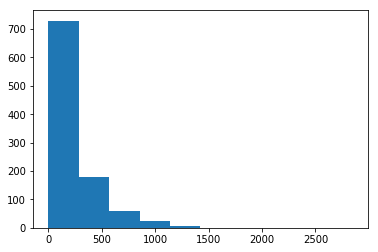

In [16]:
p = 1 / allergens_sample.sequences.apply(len).mean()
noise_sizes = 25 + np.random.geometric(p, size=(1000))
plt.hist(np.random.geometric(p, size=(1000)))
plt.show()
noise_sample = [''.join(np.random.choice(VOCAB, sz).tolist()) for sz in noise_sizes] 

# Edit Distance : Similarity Measurement

In [10]:
n_sample = 100

from tqdm import tqdm

allergens_lenghts = [len(itm) for itm in allergens_df.sequences.values]
swiss_lenghts = [len(itm) for itm in swiss_df.sequences.values]
lenghts = swiss_lenghts

swiss_allergens_list = []
swiss_noise_list = []
allergens_noise_list = []

pfam_swiss_list = []
pfam_noise_list = []
pfam_allergens_list = []

for _ in tqdm(range(100)):
    swiss_sample = swiss_df.sequences.sample(n_sample).values
    allergens_sample = allergens_df.sequences.sample(n_sample).values
    pfam_sample = pfam_df.sequences.sample(n_sample).values


    noise_sizes = np.random.choice(lenghts, size=n_sample)
    noise_sample = [''.join(np.random.choice(VOCAB, sz, replace=True).tolist()) for sz in noise_sizes] 

    distances_swiss_allergens = [editdistance.eval(s1, s2) for s1 in swiss_sample for s2 in allergens_sample]
    distances_swiss_noise = [editdistance.eval(s1, s2) for s1 in swiss_sample for s2 in noise_sample]
    distances_allergens_noise = [editdistance.eval(s1, s2) for s1 in allergens_sample for s2 in noise_sample]
    distances_pfam_swiss = [editdistance.eval(s1, s2) for s1 in pfam_sample for s2 in swiss_sample]
    distances_pfam_noise = [editdistance.eval(s1, s2) for s1 in pfam_sample for s2 in noise_sample]
    distances_pfam_allergens = [editdistance.eval(s1, s2) for s1 in pfam_sample for s2 in allergens_sample]
    
    swiss_allergens_list.append(np.mean(distances_swiss_allergens))
    swiss_noise_list.append(np.mean(distances_swiss_noise))
    allergens_noise_list.append(np.mean(distances_allergens_noise))
    pfam_swiss_list.append(np.mean(distances_pfam_swiss))
    pfam_noise_list.append(np.mean(distances_pfam_noise))
    pfam_allergens_list.append(np.mean(distances_pfam_allergens))

100%|██████████| 100/100 [08:51<00:00,  5.31s/it]


In [11]:
swiss_allergens = np.array(swiss_allergens_list).mean()
swiss_noise = np.array(swiss_noise_list).mean()
allergens_noise = np.array(allergens_noise_list).mean()
pfam_swiss = np.array(pfam_swiss_list).mean()
pfam_noise = np.array(pfam_noise_list).mean()
pfam_allergens = np.array(pfam_allergens_list).mean()

print('transfer vs allergens dataset distance:', swiss_allergens)
print('transfer vs noise dataset distance:', swiss_noise)
print('allergens vs noise dataset distance:', allergens_noise)
print('pfam vs swiss dataset distance :', pfam_swiss)
print('pfam vs noise dataset distance :', pfam_noise)
print('pfam vs allergens dataset distance :', pfam_allergens)

transfer vs allergens dataset distance: 396.14071200000006
transfer vs noise dataset distance: 439.671664
allergens vs noise dataset distance: 410.631351
pfam vs swiss dataset distance : 356.70677300000006
pfam vs noise dataset distance : 367.303473
pfam vs allergens dataset distance : 291.783017


# Vis

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
swiss_allergens = 396.14071200000006
swiss_noise = 439.671664
allergens_noise = 410.631351
pfam_swiss = 356.70677300000006
pfam_noise = 367.303473
pfam_allergens = 291.783017

distances = pd.DataFrame({
        'Riken': [None, swiss_allergens, pfam_allergens, allergens_noise],
        'SwissProt': [swiss_allergens, None, pfam_swiss, swiss_noise],
        'PFAM': [pfam_allergens, pfam_swiss, None, pfam_noise],
        'Noise': [allergens_noise, swiss_noise, pfam_noise, None],}, index=['Riken', 'SwissProt', 'PFAM', 'Noise']
)

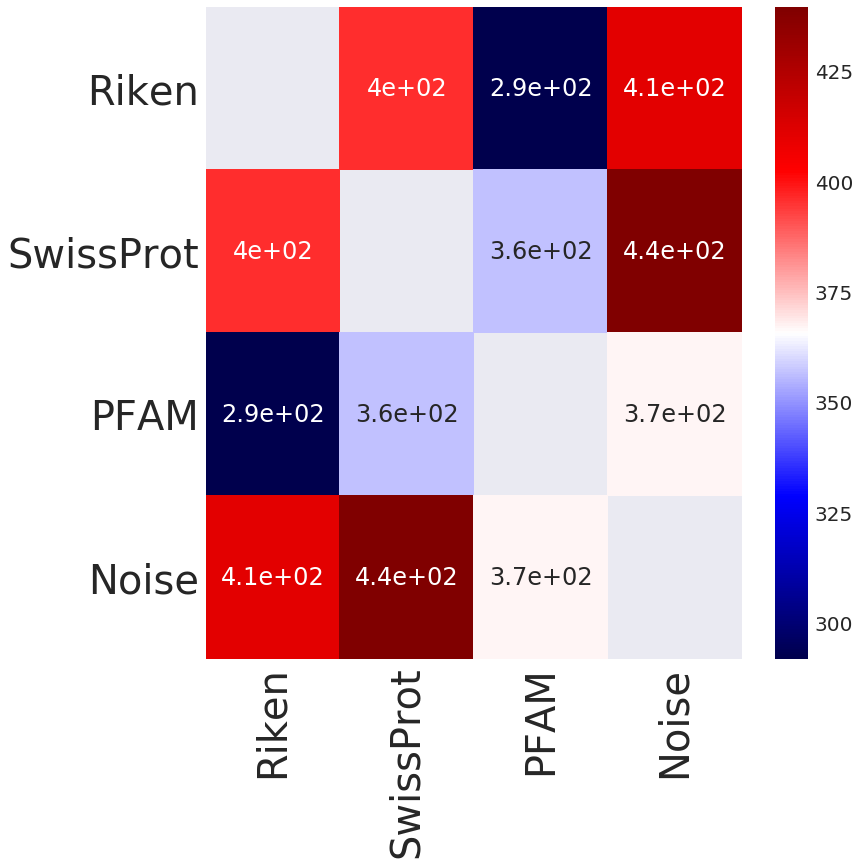

In [20]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.set(font_scale = 2)
ax = sns.heatmap(distances, annot=True, cmap='seismic', ax=ax)

plt.savefig('distances_vis.png')

# Word2Vec : Similarity Measurement

## One sample

In [97]:
feature_tool = Pipeline([
    ('ProteinTokenizer', classification_tools.ProteinTokenizer(token_size=4)),
    ('ProteinVectorization', classification_tools.ProteinW2VRepresentation(model_path=model_path,
                                                                           agg_mode='sum')),
])

pfam_vec = feature_tool.fit_transform(pfam_sample.sequences.values)
allergens_vec = feature_tool.fit_transform(allergens_sample.sequences.values)
noise_vec = feature_tool.fit_transform(noise_sample)

/home/pierre/.conda/envs/python3/lib/python3.5/site-packages/Bio/Seq.py:163: BiopythonWarning: Biopython Seq objects now use string comparison. Older versions of Biopython used object comparison. During this transition, please use hash(id(my_seq)) or my_dict[id(my_seq)] if you want the old behaviour, or use hash(str(my_seq)) or my_dict[str(my_seq)] for the new string hashing behaviour.
  "the new string hashing behaviour.", BiopythonWarning)
/home/pierre/.conda/envs/python3/lib/python3.5/site-packages/Bio/Seq.py:163: BiopythonWarning: Biopython Seq objects now use string comparison. Older versions of Biopython used object comparison. During this transition, please use hash(id(my_seq)) or my_dict[id(my_seq)] if you want the old behaviour, or use hash(str(my_seq)) or my_dict[str(my_seq)] for the new string hashing behaviour.
  "the new string hashing behaviour.", BiopythonWarning)


In [105]:
pfam_allergens = cosine_similarity(pfam_vec, allergens_vec)
pfam_noise = cosine_similarity(pfam_vec, noise_vec)
allergens_noise = cosine_similarity(allergens_vec, noise_vec)

## Many samples

In [114]:
n_sample = 1500

from tqdm import tqdm

pfam_allergens_list = []
pfam_noise_list = []
allergens_noise_list = []

for _ in tqdm(range(100)):
    pfam_sample = pfam_df.sample(n_sample)
    allergens_sample = allergens_df.sample(n_sample)

    p = 1 / allergens_sample.sequences.apply(len).mean()
    noise_sizes = 25 + np.random.geometric(p, size=(n_sample))
    noise_sample = [''.join(np.random.choice(VOCAB, sz, replace=True).tolist()) for sz in noise_sizes] 

    pfam_vec = feature_tool.fit_transform(pfam_sample.sequences.values)
    allergens_vec = feature_tool.fit_transform(allergens_sample.sequences.values)
    noise_vec = feature_tool.fit_transform(noise_sample)

    pfam_allergens_list.append(cosine_similarity(pfam_vec, allergens_vec).mean())
    pfam_noise_list.append(cosine_similarity(pfam_vec, noise_vec).mean())
    allergens_noise_list.append(cosine_similarity(allergens_vec, noise_vec).mean())
    
pfam_allergens = np.array(pfam_allergens_list).mean()
pfam_noise = np.array(pfam_noise_list).mean()
allergens_noise = np.array(allergens_noise_list).mean()

print(pfam_allergens)
print(pfam_noise)
print(allergens_noise)